<a href="https://colab.research.google.com/github/yubin8773/2021-deep-learning/blob/main/00_train_figure_save.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
np.zeros((1),np.int8) - np.ones((1),np.int8)

array([-1], dtype=int8)

In [ ]:
import numpy as np
import tensorflow as tf
import cv2, os, glob, random
import matplotlib.pyplot as plt

import imgaug.augmenters as iaa
import imgaug as ia

from tensorflow.keras.layers import *
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## argument

In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

ramdom_seed = 5198
tf.random.set_seed(ramdom_seed)
np.random.seed(ramdom_seed)
random.seed(ramdom_seed)
os.environ['PYTHONHASHSEED'] = str(ramdom_seed)
init_k = tf.keras.initializers.he_normal(seed=ramdom_seed)


## data loader

In [ ]:
# raw_data = np.load('data/202109/all_data_np.npy')
# data_input = np.reshape(raw_data, (-1,16,150))/1.8
# data_label = np.load('data/202108/label.npy')/10

In [ ]:
def envelope_(data_input):
    
    data_envelope = np.zeros((data_input.shape[0],data_input.shape[1]))
    for i in range(data_envelope.shape[0]):
        for j in range(data_envelope.shape[1]):
            data_envelope[i,j] = np.percentile(data_input[i,j], 40)
    return data_envelope


In [ ]:
raw_data = np.load('/content/drive/MyDrive/RF data/data_sum_1008.npy')
data_input = np.reshape(raw_data, (-1,16,150))/1.8
data_envelope1 = envelope_(data_input)



In [ ]:
posi = np.load('/content/drive/MyDrive/RF data/posnum_sum_1008.npy')
data_1 = np.zeros((11,11,1,8,16))
count = 0
for i in range(len(posi)):
    data_1[posi[i][0],posi[i][1],posi[i][2],posi[i][3]] = data_envelope1[i]


In [ ]:
"""
for z in range(8):
    plt.figure(figsize=(10, 10))
    for i in range(16):
        plt.subplot(4, 4, i+1) 
        plt.imshow(data_1[:,:,0,z,i],vmin = 0, vmax = data_1.max())
        plt.axis('off')
        plt.tight_layout()
    plt.savefig(f'visual/visualize/{z:04d}.png')
    plt.close()
"""

"\nfor z in range(8):\n    plt.figure(figsize=(10, 10))\n    for i in range(16):\n        plt.subplot(4, 4, i+1) \n        plt.imshow(data_1[:,:,0,z,i],vmin = 0, vmax = data_1.max())\n        plt.axis('off')\n        plt.tight_layout()\n    plt.savefig(f'visual/visualize/{z:04d}.png')\n    plt.close()\n"

In [ ]:
raw_data = np.load('/content/drive/MyDrive/RF data/data_sum_1008.npy')
data_input = np.reshape(raw_data, (-1,16,150))/1.8
data_envelope1 = envelope_(data_input)
data_label = np.load('/content/drive/MyDrive/RF data/posnum_sum_1008.npy')/10
# raw_data = np.load('data/202109_1/posnum_np_0916_no_z.npy')
# data_input = np.reshape(raw_data, (-1,16,150))/1.8
# data_envelope2 = envelope_(data_input)
# data_envelope = np.concatenate((data_envelope1, data_envelope2))
# data_label = np.concatenate((np.load('data/202108/label.npy')/10, np.load('data/202108/label.npy')/10))

In [ ]:
# idx = list(np.arange(len(data_envelope1[5444:])))
# rand_idx = random.sample(idx, 1089)
# complement = list(set(idx) - set(rand_idx))

In [ ]:
X_train = data_envelope1[:1089*5]
Y_train = data_label[:1089*5]
x_val = data_envelope1[1089*5:]
y_val = data_label[1089*5:]

In [ ]:
# def image_aug_batch(img):
#     seq = iaa.Sequential([
#     iaa.Multiply((0.9, 1.1)), 
#     iaa.Affine(
#         translate_px={"x": 10, "y": 10},
#         scale=(0.95, 1.05),
#         rotate=(-180, 180)),
#     iaa.Fliplr(0.5),
#     iaa.Flipud(0.5)
#     ])
#     images_aug = seq(images = img.astype(np.float32)/255.)
#     return images_aug

In [ ]:
def data_generator(train_imgs, train_labels, batch_size, aug = True):
    idx = 0
    idx_list = list(range(0,len(train_imgs)))
    random.shuffle(idx_list)
    while 1:
        if idx > len(idx_list) - batch_size:
            tmp_list = idx_list[idx:]
            idx = 0
        else:
            tmp_list = idx_list[idx:idx + batch_size]
            idx = idx + batch_size
        batch_images = train_imgs[tmp_list]
        batch_labels = train_labels[tmp_list]
        
        # if aug == True:
        #     batch_images = image_aug_batch(batch_images)
        #     batch_images = (batch_images * 255).astype(np.uint8)
        #     batch_images = np.clip(batch_images, 0, 255)
        batch_images = batch_images
        yield batch_images, [batch_labels[:,:3], batch_labels[:,3]]

In [ ]:
batch_size = 256
train_gen = data_generator(X_train, Y_train, batch_size, aug = True)
val_gen = data_generator(x_val, y_val, batch_size, aug = False)
# test_gen = data_generator(X_test, y_test, batch_size, aug = False)

## model

In [ ]:
input_shape = (16)
input_ = Input(input_shape)
x = Dense(64, activation='relu')(input_)
x = BatchNormalization()(x)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
r = Dense(64, activation='relu')(x)
r = BatchNormalization()(r)
p = Dense(64, activation='relu')(x)
p = BatchNormalization()(p)
pos = Dense(3, activation='sigmoid')(p)
rot = Dense(1, activation='sigmoid')(r)
model = tf.keras.models.Model(input_, [pos, rot])

In [ ]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 16)]         0                                            
__________________________________________________________________________________________________
dense_36 (Dense)                (None, 64)           1088        input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_24 (BatchNo (None, 64)           256         dense_36[0][0]                   
__________________________________________________________________________________________________
dense_37 (Dense)                (None, 64)           4160        batch_normalization_24[0][0]     
____________________________________________________________________________________________

In [ ]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0005),
              loss=tf.keras.losses.MSE, loss_weights=[1,1], metrics=['mae'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


## save path

In [ ]:
file_save_name = 'saved_model/01_test'

try:
    if not os.path.exists(file_save_name):
        os.makedirs(file_save_name)
except OSError:
    print ('Error: Creating directory. ' +  file_save_name)

In [ ]:
filepath = f'{file_save_name}' + '/model-{epoch:04d}.h5'
checkpoint = ModelCheckpoint(filepath, save_weights_only=True)

## train

In [ ]:
model_hist = model.fit_generator(train_gen, epochs = 1000, steps_per_epoch = int(len(data_input)/batch_size)+1, callbacks = [checkpoint], validation_data=val_gen, validation_steps=5)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/1000
26/26 [==============================] - 2s 12ms/step - loss: 0.1787 - dense_40_loss: 0.1302 - dense_41_loss: 0.0484 - dense_40_mae: 0.2892 - dense_41_mae: 0.1816 - val_loss: 0.2072 - val_dense_40_loss: 0.1342 - val_dense_41_loss: 0.0731 - val_dense_40_mae: 0.3315 - val_dense_41_mae: 0.2276
Epoch 2/1000
26/26 [==============================] - 0s 5ms/step - loss: 0.1145 - dense_40_loss: 0.0866 - dense_41_loss: 0.0280 - dense_40_mae: 0.2312 - dense_41_mae: 0.1372 - val_loss: 0.1837 - val_dense_40_loss: 0.1128 - val_dense_41_loss: 0.0709 - val_dense_40_mae: 0.3054 - val_dense_41_mae: 0.2239
Epoch 3/1000
26/26 [==============================] - 0s 5ms/step - loss: 0.0878 - dense_40_loss: 0.0680 - dense_41_loss: 0.0198 - dense_40_mae: 0.2040 - dense_41_mae: 0.1129 - val_loss: 0.1627 - val_dense_40_loss: 0.0968 - val_dense_41_loss: 0.0659 - val_dense_40_mae: 0.2829 - val_dense_41_mae: 0.2180
Epoch 4/1000
26/26 [==============================] - 0s 5ms/step - loss: 0.0684 - dens

KeyboardInterrupt: ignored

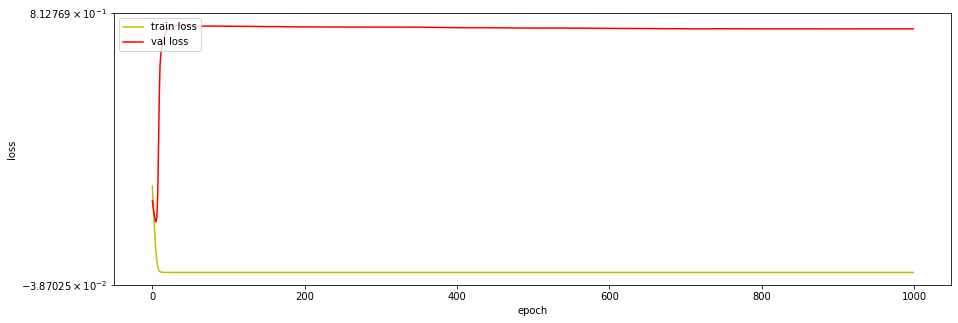

In [ ]:
fig, loss_ax = plt.subplots(figsize =(15,5))

loss_ax.plot(model_hist.history['loss'], 'y', label='train loss')
loss_ax.plot(model_hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')
loss_ax.set_yscale('symlog')

plt.show()

In [ ]:
predi = model.predict(x_val) * 10

In [ ]:
predi_round = np.round(predi[0],2)

In [ ]:
predi_round[10:20]

array([[0.02, 0.04, 0.  ],
       [0.07, 0.07, 0.  ],
       [0.03, 0.11, 0.  ],
       [0.05, 0.16, 0.  ],
       [0.18, 0.05, 0.  ],
       [0.2 , 0.02, 0.  ],
       [0.08, 0.04, 0.  ],
       [0.02, 0.07, 0.  ],
       [0.01, 0.23, 0.  ],
       [0.07, 0.1 , 0.  ]], dtype=float32)

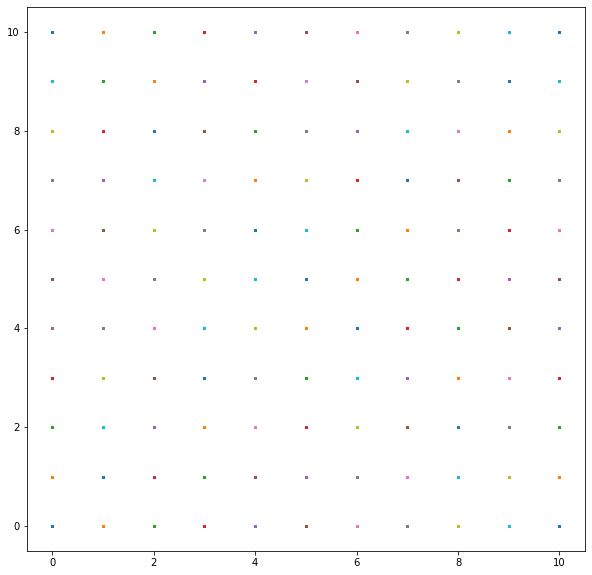

In [ ]:
plt.figure(figsize = (10,10))
for i in range(int(len(predi_round)/9)):
    plt.scatter(data_label[i*9:i*9+9,0]*10, data_label[i*9:i*9+9,1]*10, s = 3)

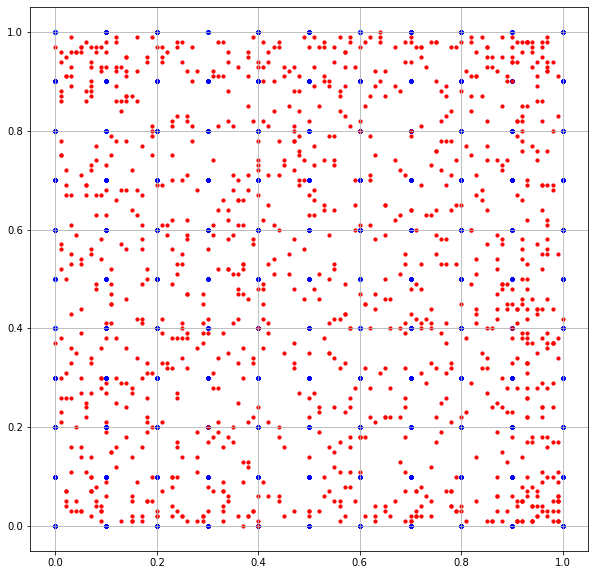

In [ ]:
plt.figure(figsize = (10,10))
plt.scatter(y_val[:,0], y_val[:,1], s = 10, c = 'b')
plt.scatter(predi_round[:,0], predi_round[:,1], s=10, c = 'r')
plt.grid(0.1)
plt.show()

In [ ]:
for z in range(0,int(len(predi_round)/9),8):
    for y in range(8):
        i = z+y
        plt.figure(figsize = (10,10))
        plt.scatter(y_val[i,0], y_val[i,1], s = 10, c = 'b')
        plt.scatter(predi_round[i,0], predi_round[i,1], s=10, c = 'r')
        plt.grid(0.1)
        plt.xlim(-0.01,1.01)
        plt.ylim(-0.01,1.01)
    plt.savefig(f'/content/drive/MyDrive/RF data/{z:04d}.png')
    plt.close()

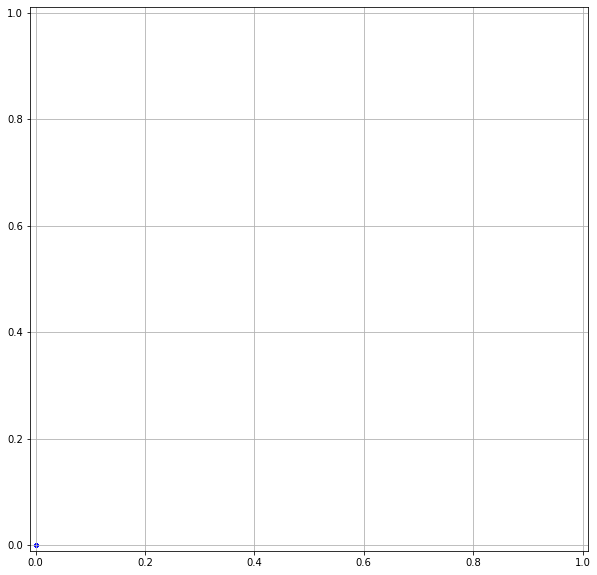

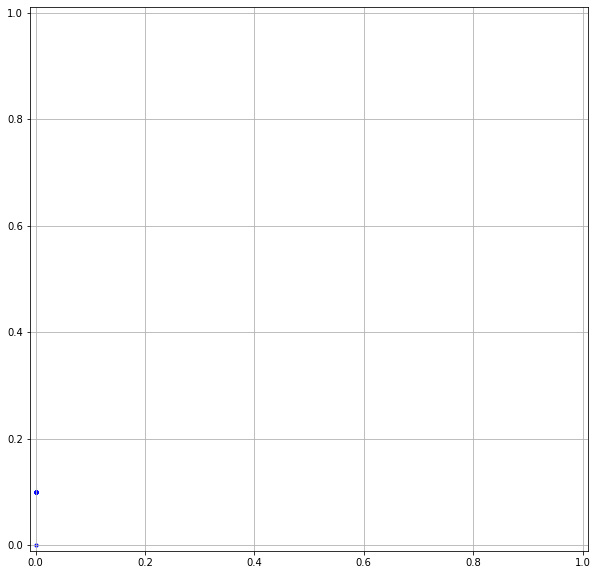

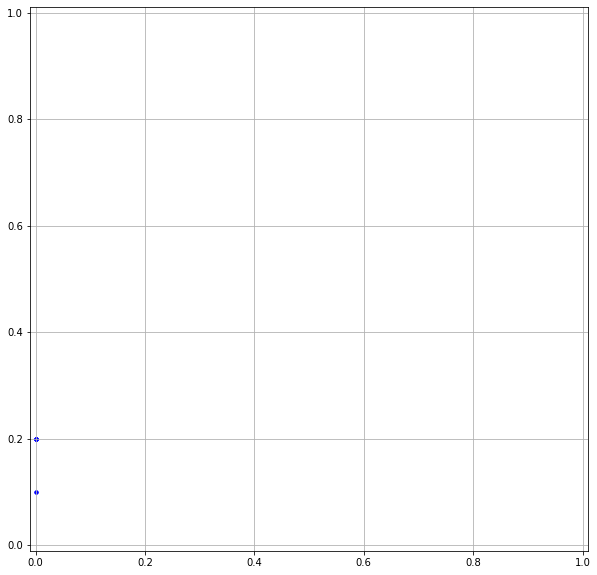

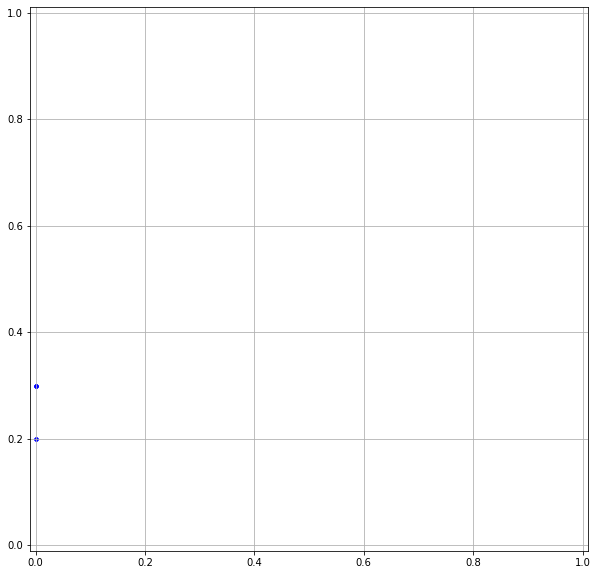

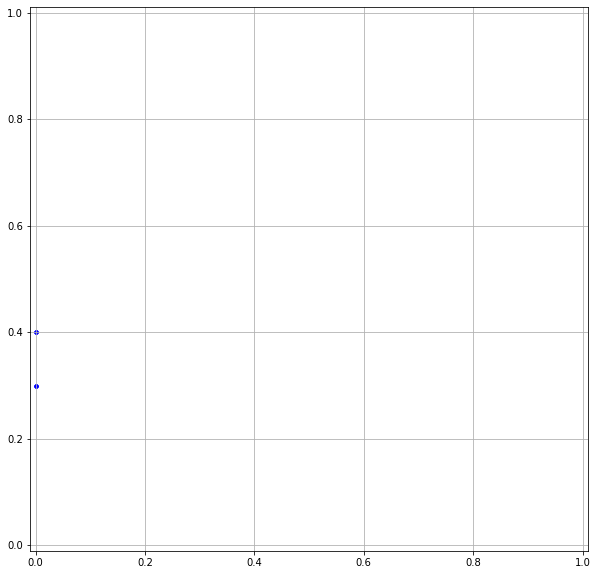

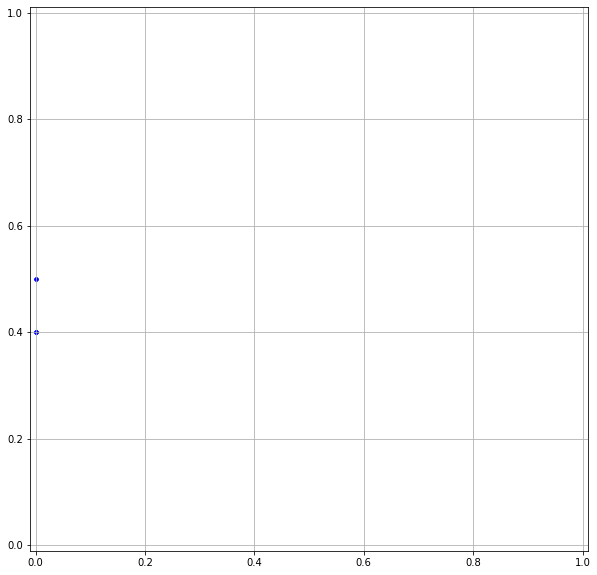

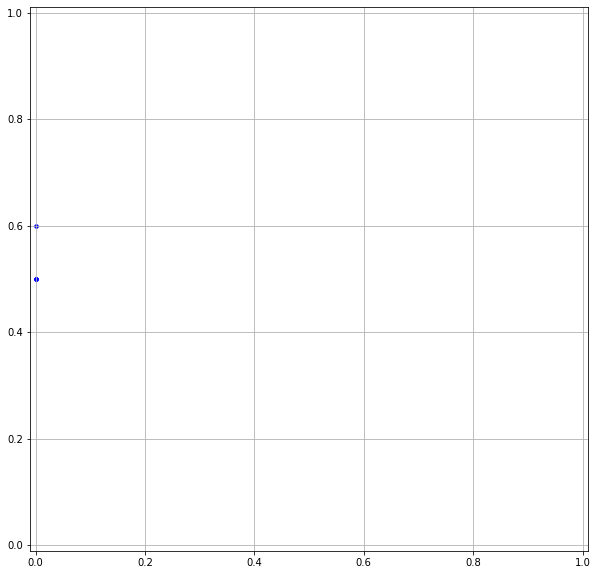

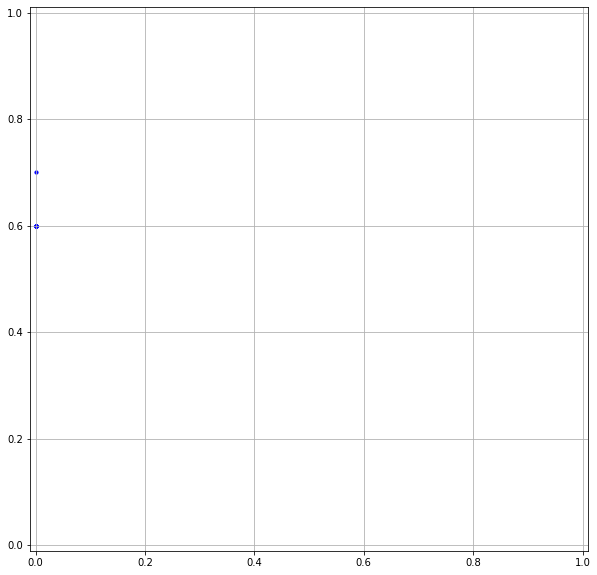

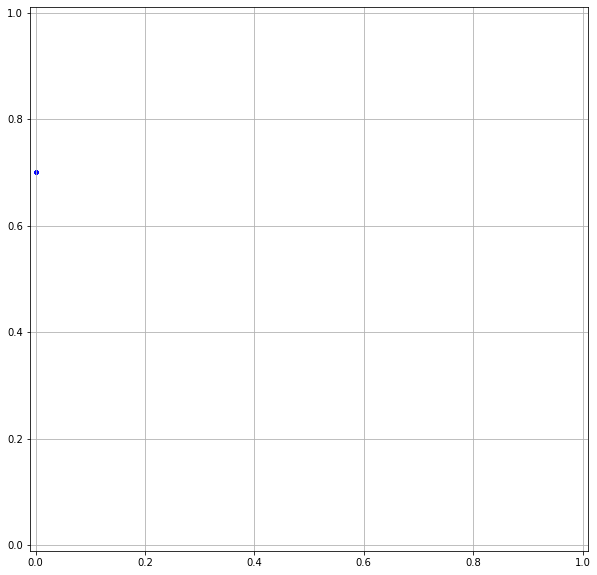

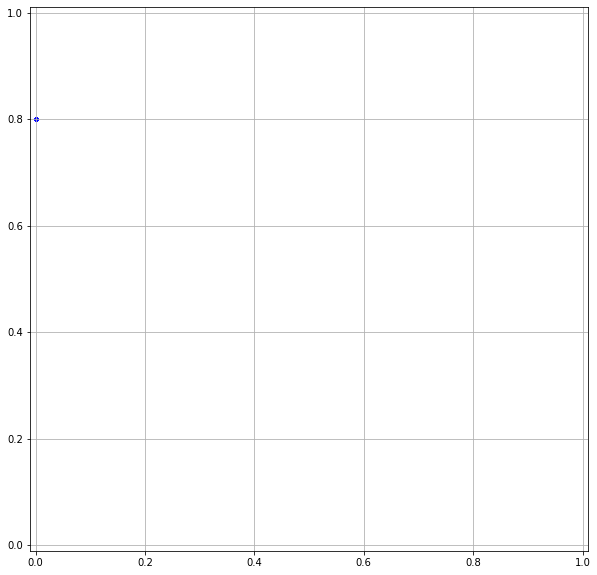

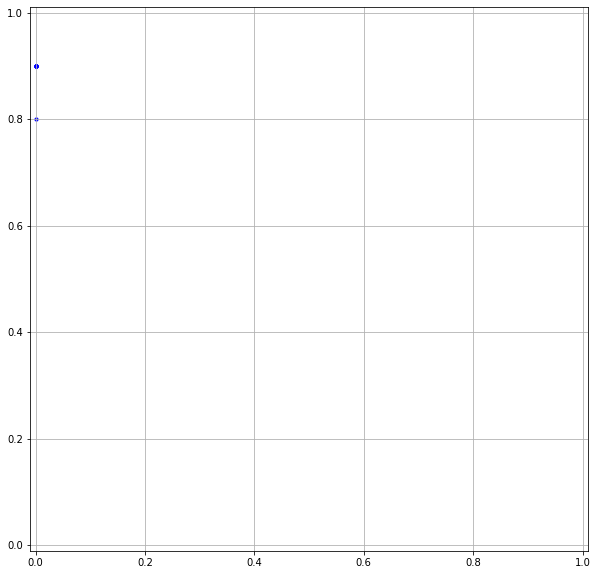

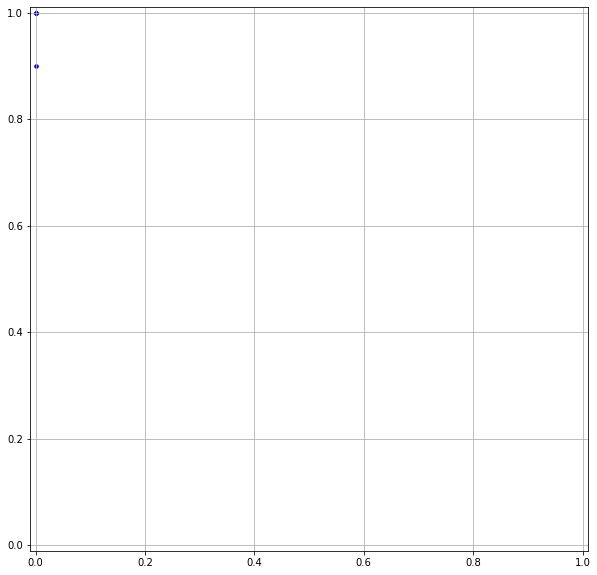

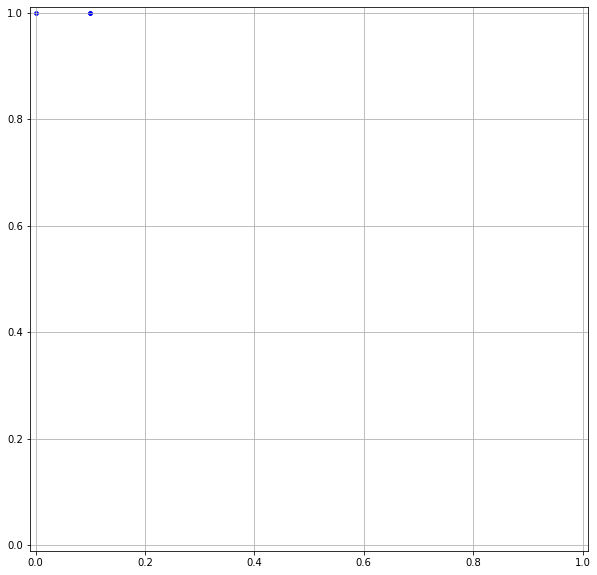

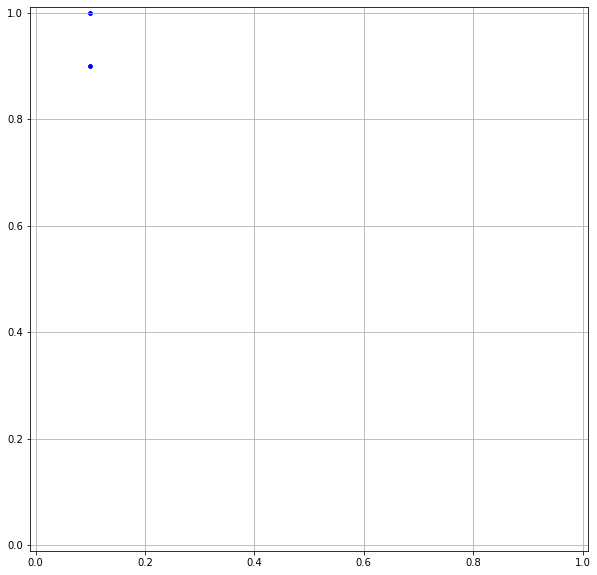

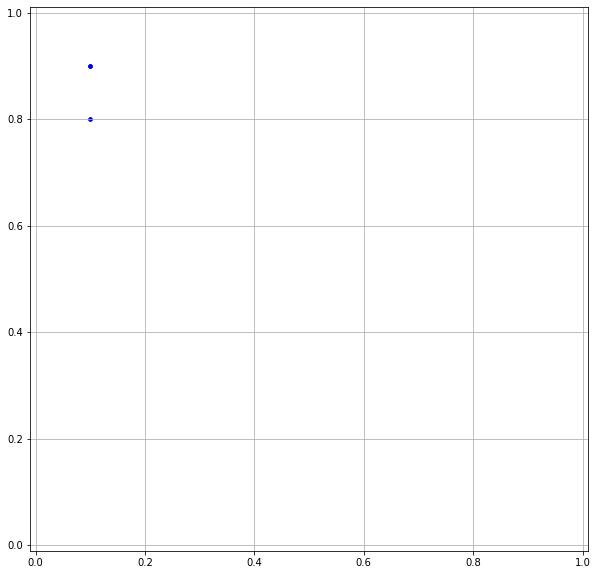

In [ ]:
for z in range(0,int(len(predi_round)/9),8):
    plt.figure(figsize = (10,10))
    plt.scatter(y_val[z:z+8,0], y_val[z:z+8,1], s = 10, c = 'b')
    plt.scatter(predi_round[z:z+8,0], predi_round[z:z+8,1], s=10, c = 'r')
    plt.grid(0.1)
    plt.xlim(-0.01,1.01)
    plt.ylim(-0.01,1.01)
    plt.savefig(f'/content/drive/MyDrive/RF data/{z:04d}.png')  
    plt.close()